## Modeling scATAC-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


/home/ilibarra/.conda/envs/mubind_cpu/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind_cpu/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [7]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [8]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [9]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [10]:
device = 'cpu'

In [11]:
import scanpy as sc

In [12]:
print('here...')

here...


In [13]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


In [14]:
rna.shape, atac.shape

((16918, 14663), (16918, 228259))

In [16]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


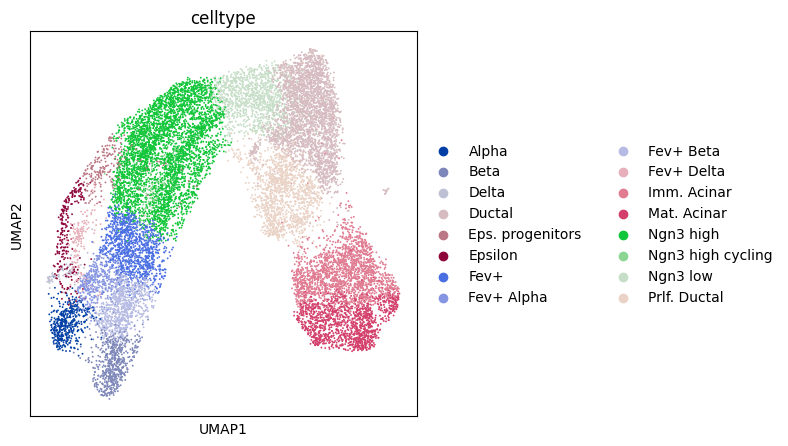

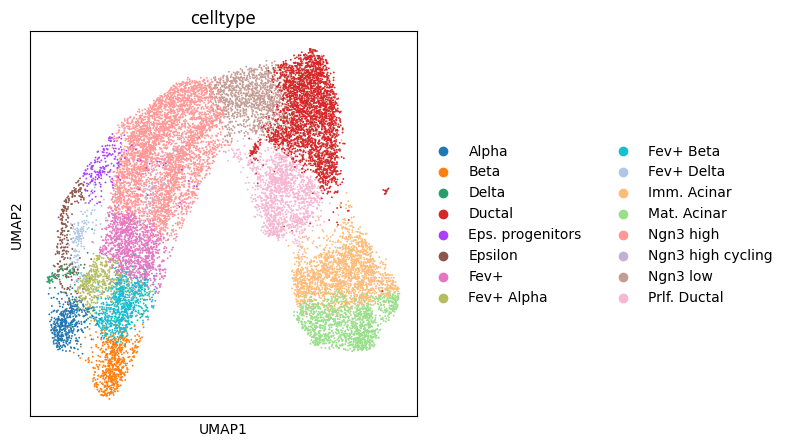

In [17]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [18]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [19]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [20]:
rna

AnnData object with n_obs × n_vars = 16918 × 14663
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
    var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'uns

In [21]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

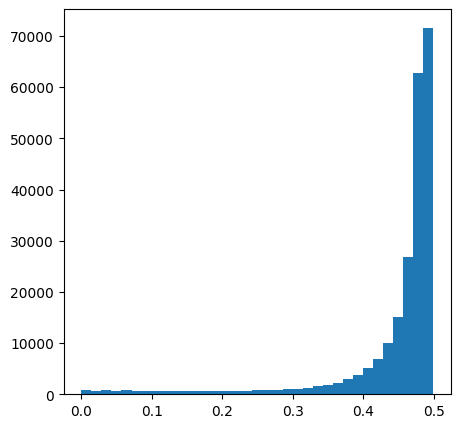

In [22]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [23]:
n_sample_cells = 500
n_sample_peaks = 250

In [24]:
n_cell_types = len(set(atac.obs['celltype']))

In [25]:
 # int(n_sample_cells * 1.5)
obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells).index # pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(496, 250)

In [26]:
ad.obs['celltype'].value_counts()

celltype
Alpha                31
Beta                 31
Delta                31
Ductal               31
Eps. progenitors     31
Epsilon              31
Fev+                 31
Fev+ Alpha           31
Fev+ Beta            31
Fev+ Delta           31
Imm. Acinar          31
Mat. Acinar          31
Ngn3 high            31
Ngn3 high cycling    31
Ngn3 low             31
Prlf. Ductal         31
Name: count, dtype: int64

In [27]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [28]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(496, 496)

In [ ]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

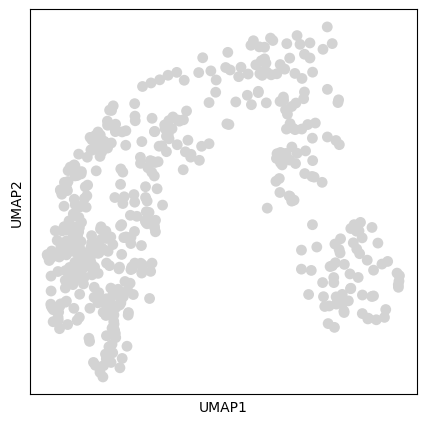

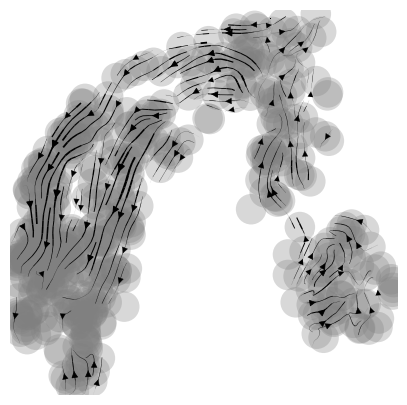

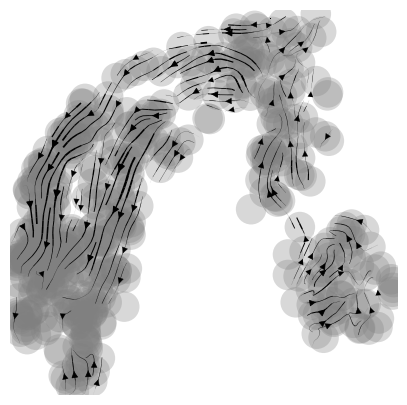

In [30]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [31]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr4     22
chr9     20
chr5     17
chr11    17
chr3     16
chr7     16
chr13    14
chr1     14
chr2     13
chr12    13
chr6     13
chr8     12
chr10    11
chr16    10
chr17     9
chr14     8
chr15     8
chr18     8
chr19     8
chrX      1
Name: count, dtype: int64

In [32]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [33]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.local/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpg4rdlw1y
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.local/bin/bedtools', 'getfasta', '-fi', '../../../annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpg4rdlw1y', '-fo', '/tmp/tmpodc2jxwl']
/home/ilibarra/.local/bin/bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpg4rdlw1y -fo /tmp/tmpodc2jxwl


250

In [35]:
len(seqs)

250

In [36]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [37]:
counts.shape

(250, 496)

In [38]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [39]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [40]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(250, 497)

In [42]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(250, 497)

In [41]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [43]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [44]:
# next_data.index

In [45]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [46]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [47]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(250, 496)

In [48]:
ad.shape, df.shape

((496, 250), (250, 496))

In [49]:
ad = ad[:,~zero_counts].copy()


In [50]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(124000, 3)
496
batch
184    250
185    250
186    250
187    250
188    250
      ... 
3      250
4      250
5      250
6      250
7      250
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CGCCTCCTCGGCGGGCGGGCCTTAGGACGAGCGAGGCACTCCATTGGTAGATCTTCATGCCGGTCATAGGGGATCCACCCCCCCAGTTTTTTTTTTTCCC,1.0,1.0,0
CAGGGTCCCGCGAGAACTTCCCCACGCGGCCCCGCCCCGCCGCGCCCCGCCCCCGCGAGACTTCCCCCGGCGGAAAAGGCCCAGAGCGCAAGCGCTCCTC,1.0,0.0,0
GCCAGGCCCGCTCCTGAGGGGACGGACTCCCGCCCGCCCTCACACCGCGCCTCACGCCAGGCCCCCAGGCTTCGGGTACCTCTCACCTTTGACGACGCGG,1.0,0.0,0
AAGCCGCAGTGCCCCGCCGAGGCCCGCAGCCCACGGCCCCCCGCGCTCCTCACCGGTCCGGCCCGGAGCCCACCTCTCGGCCGCCGCCGCAGCCACCTCG,1.0,0.0,0
CGGCCCTCCCCCCTCCTAAAGCGCACGCGCAAGCCAAGGCCCCCATTGCTTTAACAAACACATTTCTGGGAACTGGCCTACTGTATTTCTCAGTGACAGA,1.0,1.0,0


### Simple motif enrichment

In [51]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [52]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [53]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [54]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [55]:
reduced_groups = pwms

In [56]:
df

,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
seq,,,,,,,,,,,,,,,,,,,,,
CGCCTCCTCGGCGGGCGGGCCTTAGGACGAGCGAGGCACTCCATTGGTAGATCTTCATGCCGGTCATAGGGGATCCACCCCCCCAGTTTTTTTTTTTCCC,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,...,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
CAGGGTCCCGCGAGAACTTCCCCACGCGGCCCCGCCCCGCCGCGCCCCGCCCCCGCGAGACTTCCCCCGGCGGAAAAGGCCCAGAGCGCAAGCGCTCCTC,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,...,2.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
GCCAGGCCCGCTCCTGAGGGGACGGACTCCCGCCCGCCCTCACACCGCGCCTCACGCCAGGCCCCCAGGCTTCGGGTACCTCTCACCTTTGACGACGCGG,0.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,2.0,...,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0
AAGCCGCAGTGCCCCGCCGAGGCCCGCAGCCCACGGCCCCCCGCGCTCCTCACCGGTCCGGCCCGGAGCCCACCTCTCGGCCGCCGCCGCAGCCACCTCG,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
CGGCCCTCCCCCCTCCTAAAGCGCACGCGCAAGCCAAGGCCCCCATTGCTTTAACAAACACATTTCTGGGAACTGGCCTACTGTATTTCTCAGTGACAGA,1.0,3.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,3.0,...,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCTACCTTGAACCTGGGTTCTGTAATACTACCTGCTGTCAATAGCTGGGGATTCTGACACGATCAGCCTTAGTGCTGTGACACTTGTTGCTGTGGAGCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAAGCTGTGTCTGGATACTTTTGATATGAGTTCCTTCAGTCTTAGAGGGAACAGCAGGTGCTGGGGTGCAGGCAGCAGATCCTAACATTTGTGTGAGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGCAGAGGAAGCAATGGTACTCTGTCCTAATTCCTTCAGGGCCACTGGGAACCAGGGTATTCTGACAATCTCTGTGAAGGTAGGACTCTTCTGAGAAAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [58]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [59]:
len(pwms)

286

In [60]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [61]:
rna_sample.shape, ad.shape

((496, 14663), (496, 250))

In [71]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(496, 496)
setting up log dynamic
no err


In [65]:
model.graph_module.conn_sparse.shape

torch.Size([496, 496])

setting up log dynamic
True
12
order None
0 out of 288...
break


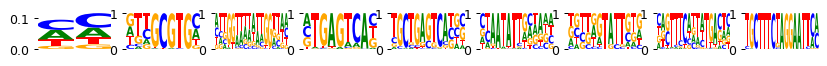

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 76/150 [00:35<00:48,  1.53it/s]

Epoch: 76, Loss: 227.055801, R2: 0.34,  best epoch: 74,  secs per epoch: 0.471 s,  secs epoch*1k trials: 1.885s curr time: 2024-05-15 00:14:58.241076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:11<00:00,  2.10it/s]


Current time: 2024-05-15 00:15:34.927753
	Loss: 191.6777496338 , R2: 0.35
	Training time (model/function): (71.516s / 71.516s)
		per epoch (model/function): (0.480s/ 0.480s)
		per 1k samples: 1.920s
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


Current time: 2024-05-15 00:16:02.327641
	Loss: 175.8773498535 , R2: 0.35
	Training time (model/function): (98.057s / 26.541s)
		per epoch (model/function): (2.001s/ 0.542s)
		per 1k samples: 2.167s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 20%|██████████████████████████████████████▍                                                                                                                                                         | 10/50 [00:05<00:23,  1.73it/s]


KeyboardInterrupt: 

In [67]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 50
log_each=75

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [ ]:
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [ ]:
ad.write('atac_train.h5ad')
rna_sample.write('rna_sample_train.h5ad')

In [ ]:
import pickle
pickle.dump(train, open('train_dataloader.pkl', 'wb'))